Pendientes:
- Por qué escogí el modelo de embeddings:
  - https://python.langchain.com/docs/integrations/text_embedding/
-  Hacer pruebas con diferentes vector_store
  - Por ejm con chrome y faiss
- 


In [1]:
import os
from dotenv import load_dotenv

from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings


In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
DIR_PATH = "C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/sagemaker_documentation/sagemaker_documentation"
CHUNK_SIZE_SPLIT = 1000
CHUNK_OVERLAP = 200
LLM_MODEL = "gpt-3.5-turbo"
# LLM_MODEL = "llama2"
TEMPERATURE = 0

In [4]:
# Load documents
loader = DirectoryLoader(
    DIR_PATH, glob="*.md", loader_cls=UnstructuredMarkdownLoader
)
docs = loader.load()

In [5]:
# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE_SPLIT, 
    chunk_overlap=CHUNK_OVERLAP
)
splits = text_splitter.split_documents(docs)

# RAGAS expects a file_name dict as key
for document in splits:
    document.metadata['file_name'] = document.metadata['source']

In [6]:
len(splits)

1465

In [7]:
# Model decision:
if LLM_MODEL.startswith("gpt"):
    model = ChatOpenAI(api_key=OPENAI_API_KEY, model= LLM_MODEL, temperature=TEMPERATURE)
    embeddings = OpenAIEmbeddings()
else:
    model = Ollama(model=LLM_MODEL, temperature=TEMPERATURE)
    embeddings = OllamaEmbeddings()

In [8]:
# Embed and create retriever
vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [9]:
prompt_rag_template = """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. **do not cite extra resources**

Question: {question}

Context: {context} 

Answer:
"""

prompt = PromptTemplate.from_template(prompt_rag_template)

In [10]:
# LLM
llm = model

In [11]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [12]:
# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [13]:
# Question
rag_chain.invoke("Whe sage maker create a model what happen?")

'When a SageMaker creates a model, it consists of inference code, model artifacts, an IAM role, and other necessary information for deployment. Model artifacts are the outcomes of training a model using a machine learning algorithm. The inference code needs to be packaged in a Docker container and stored in Amazon ECR.'

In [14]:
rag_chain.invoke("summarize aws-resource-sagemaker-space")

'The operators access SageMaker resources on your behalf using an IAM role. This IAM role is different from the credentials used to access the Kubernetes cluster. It also differs from the role AWS assumes when running machine learning jobs.'

#### Evaluation

In [15]:
# Ragas wants ['question', 'answer', 'contexts', 'ground_truths'] as
'''
{
    "question": [], <-- question from faq doc
    "answer": [], <-- answer from generated result
    "contexts": [], <-- context
    "ground_truths": [] <-- actual answer
}
'''

from datasets import Dataset

questions = [
    "What is SageMaker?", 
    "What are all AWS regions where SageMaker is available?",
    "How to check if an endpoint is KMS encrypted?",
    "What are SageMaker Geospatial capabilities?",
    "What is Amazon SageMaker?",
    "How does SageMaker handle model training scalability?",
    "Can SageMaker integrate with other AWS services?",
    "What are SageMaker notebooks?",
    "How does SageMaker ensure model security?",
    "What is SageMaker Autopilot?",
    "How does model monitoring work in SageMaker?",
    "What types of machine learning models can SageMaker deploy?",
    "How does SageMaker optimize model performance?",
    "Can SageMaker process real-time data for predictions?"
]

ground_truths = [
    ["SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud."],
    ["AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East."],
    ["To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI."],
    ["SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis."],
    ["Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly."],
    ["SageMaker automatically scales the training jobs by adjusting the number of instances based on the workload, ensuring efficient use of resources."],
    ["Yes, SageMaker integrates seamlessly with AWS services like S3 for data storage, IAM for security, and Lambda for serverless computing, enhancing its capabilities."],
    ["SageMaker notebooks are Jupyter notebooks hosted on SageMaker, enabling data scientists to prepare and process data, visualize results, and experiment with models directly."],
    ["SageMaker uses AWS IAM to control access, encrypts data at rest using KMS, and data in transit using SSL to ensure secure model training and deployment."],
    ["SageMaker Autopilot is an automated machine learning (AutoML) service that automatically creates, trains, and tunes the best machine learning models based on the data provided."],
    ["SageMaker Model Monitor continuously tracks the models performance in production, detecting deviations in model quality to provide alerts and insights."],
    ["SageMaker supports all common machine learning models, including linear regression, classification, and deep learning models like CNNs and RNNs."],
    ["SageMaker optimizes models by using hyperparameter tuning to automatically find the best version of a model based on the defined criteria and metrics."],
    ["Yes, SageMaker offers real-time prediction capabilities through endpoints that are scalable and can process thousands of requests per second."]
]

answers = []
contexts = []

# Inference
for query in questions:
    answers.append(rag_chain.invoke(query))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    answer_similarity,
    answer_correctness,
    context_precision,
    context_recall,
    faithfulness,
    context_entity_recall
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        context_precision,
        context_recall,
        faithfulness,
        context_entity_recall
    ],
)

result

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating:  65%|██████▌   | 64/98 [01:10<00:37,  1.10s/it]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\ragas\executor.py", line 96, in run
    results = self.loop.run_until_complete(self._aresults())
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\ragas\executor.py", line 84, in _aresults
    raise e
 

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

df = result.to_pandas()
df

,question,answer,contexts,ground_truths,ground_truth,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall,context_entity_recall
0,What is SageMaker?,"SageMaker is a fully managed machine learning service by Amazon. It allows data scientists and developers to build, train, and deploy machine learning models easily. SageMaker includes an integrated Jupyter authoring notebook for data exploration and analysis without the need to manage servers.","[How Amazon SageMaker uses AWS Secrets Manager\n\nSageMaker is a fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers.]","[SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud.]","SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud.",1.000000,0.964816,0.884064,1.0,1.00,0.666667
1,What are all AWS regions where SageMaker is available?,I don't know.,[Buy and Sell Amazon SageMaker Algorithms and Models in AWS Marketplace],"[AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East.]","AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East.",0.000000,0.721907,0.180477,0.0,0.00,0.000000
2,How to check if an endpoint is KMS encrypted?,"To check if an endpoint is KMS encrypted, you can attach a policy that allows decryption of the data by notebooks accessing Amazon S3 sources and targets. This policy should be configured to work with SSE-KMS encryption. For more detailed information, refer to the documentation on Protecting Data Using Server-Side Encryption with AWS KMS-Managed Keys (SSE-KMS).","[If you plan to access Amazon S3 sources and targets that are encrypted with SSE-KMS, attach a policy that allows notebooks to decrypt the data, as shown in the following example. For more information, see Protecting Data Using Server-Side Encryption with AWS KMS-Managed Keys (SSE-KMS).]","[To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI.]","To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI.",0.993896,0.908794,0.727169,1.0,1.00,0.000000
3,What are SageMaker Geospatial capabilities?,"SageMaker geospatial capabilities allow users to perform operations on AWS hardware managed by SageMaker. Users can grant permissions for these operations using an IAM role, known as an execution role. Local execution roles can be created and used following specific procedures.","[SageMaker geospatial capabilities roles\n\nAs a managed service, Amazon SageMaker geospatial capabilities perform operations on your behalf on the AWS hardware that is managed by SageMaker. It can perform only operations that the user permits.\n\nA user can grant these permissions with an IAM role (referred to as an execution role).\n\nTo create and use a locally available execution role, you can use the following procedures.\n\nCreate an execution role]","[SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis.]","SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis.",0.998057,0.889766,0.722442,1.0,1.00,0.000000


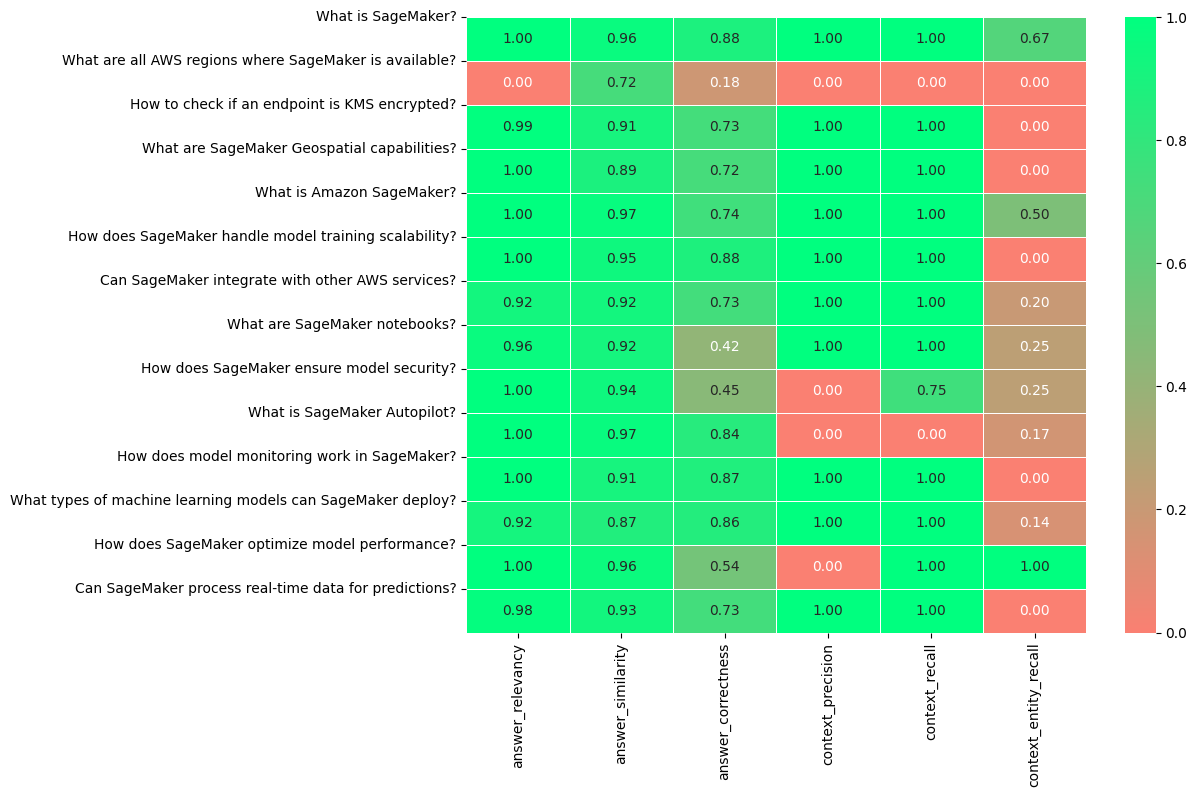

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[[
    "answer_relevancy",
    "answer_similarity",
    "answer_correctness",
    "context_precision",
    "context_recall",
    "context_entity_recall"
]]

cmap = LinearSegmentedColormap.from_list('green_red', ['salmon', 'springgreen'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

#### class uses

In [ ]:
from raga_analizer_process import RagaAnalizer

analyzer = RagaAnalizer(retriever, rag_chain)


In [ ]:
analyzer.preprocess_documents(splits)
questions, answers, contexts = analyzer.infer_answers(questions)

In [ ]:
dataset = analyzer.create_dataset(questions, answers, contexts, ground_truths)


passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 84/84 [04:16<00:00,  3.05s/it]


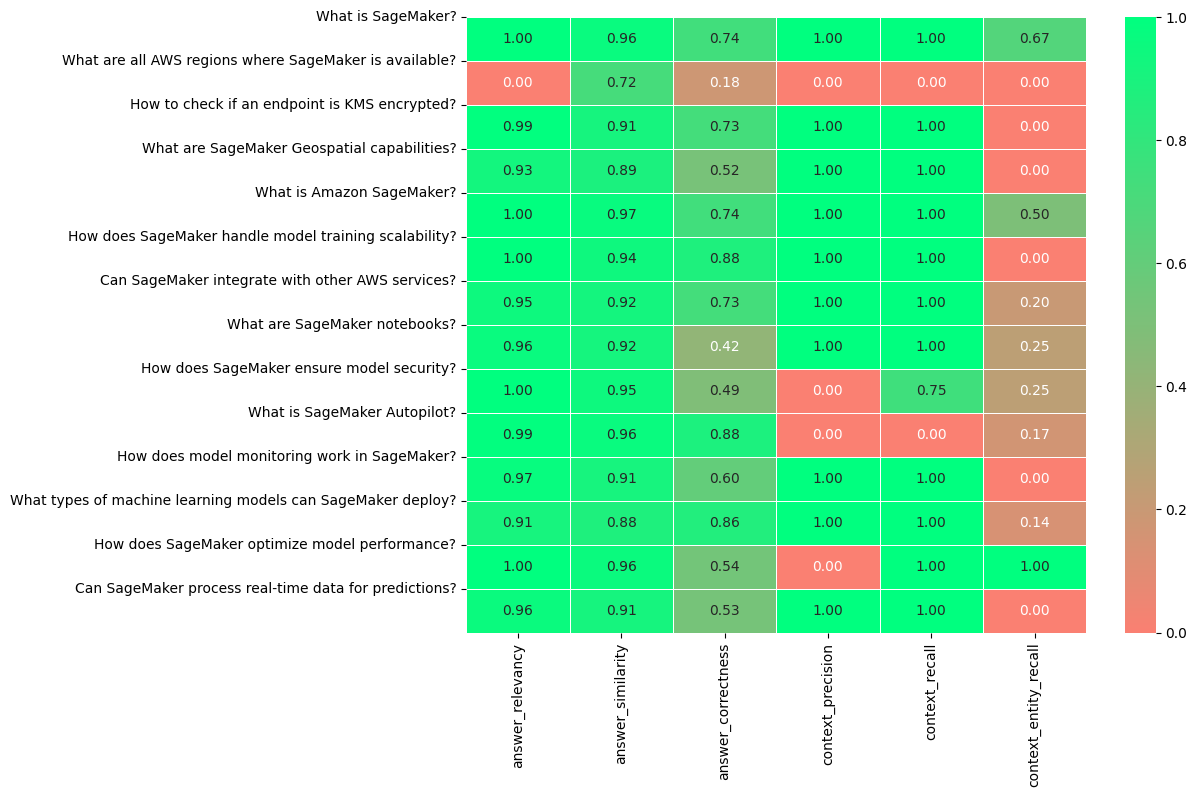

In [ ]:
results = analyzer.evaluate_answers(dataset)
analyzer.plot_results(results)